In [1]:
from keras.datasets.mnist import load_data
from keras.models import Sequential
from keras.layers import Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU, Dropout, Flatten, Dense, Reshape
from keras.optimizers import Adam

import numpy as np

from matplotlib import pyplot as plt

# This is a bit different than we're used to for other 
# MNIST networks we've built. Note that we don't care
# at all about the "class" — we are NOT trying to identify
# digits. We're only trying to make passable fakes.
(real_train_images, _), (real_test_images, _) = load_data()

Using TensorFlow backend.


In [2]:
# We have to do some slight processing of the MNIST input images.
# Specifically, keras expects 3 dimentional input, 
# height, width, and color channels.

# since we have black/white images we just use np.expand_dims
# to go from (28, 28) => (28, 28, 1). This should feel familiar,
# if you've used CNNs in keras at all.

# We're also going to normalize from the 0-255 domain to 0.0-1.0
def prepare_real_samples(samples):
    prepared_samples = np.expand_dims(samples, axis=-1)
    prepared_samples = prepared_samples.astype('float32')
    prepared_samples = prepared_samples / 255.0
    
    return prepared_samples


# Because the network is trained on the binary question
# "real" or "fake" this helper function selects a number 
# of samples from a set of samples that has already been
# "prepared" by the previous function. 

# We select a random sample, and provide the "label"
# of 1 (meaning real) for each of the selected samples.

# Crucially, we ASSUME that "samples" is a set of real
# examples prepared with prepare_real_samples. It is possible
# to pass fake/generated samples to this function, but that
# would be very bad for our GAN. 
def generate_real_batch(samples, n_samples):
    indices = np.random.randint(0, samples.shape[0], n_samples)
    batch_images = samples[indices]
    batch_labels = np.ones((n_samples, 1))

    return batch_images, batch_labels


# We're going to give our discriminator a head start
# by allowing it to train, on its own, against totally
# random noise. 

# Later, we'll add a generator network and train
# the discriniator against the output of that network.
# This function generates a number of images.
def generate_random_fake_batch(n_samples, shape=(28,28,1)):
    # Random numbers 0.0-1.0 from a uniform distribution in a flat numpy Array
    batch = np.random.rand(shape[0] * shape[1] * shape[2] * n_samples)
    
    # Unflatten the list according to the provided shape
    batch = batch.reshape((n_samples, shape[0], shape[1], shape[2]))

    # Labels are all 0, for fake
    labels = np.zeros((n_samples, 1))
    return batch, labels

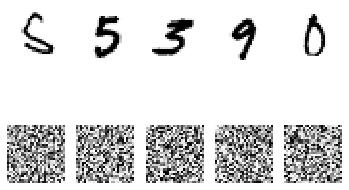

In [3]:
# Prepare the dataset
prepared_real_images = prepare_real_samples(real_train_images)

# Lets quickly visualize our "real" data vs our "fake" data.
real_x, _ = generate_real_batch(prepared_real_images, 5)
fake_x, _ = generate_random_fake_batch(5)

all_x = np.concatenate((real_x, fake_x))

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(all_x[i, :, :, 0], cmap='Greys')


In [4]:
# The discriminator accepts an image as input. The image is
# either a real example, or a generated one. The discriminator
# makes a binary decision about which it is, real or false.

# The default input shape is selected to match the MNIST dataset
# and could be changed to support other datasets.

# This simple network will be satisfactory for the simple MNIST dataset.
# Leaky, 2x2 striding, dropout, and batch normalization are all 
# suggested best practices for GAN at the time of this writting. 
# See "Resources for Further Exploration" for the reasoning.
def create_discriminator(in_shape=(28,28,1)):
    model = Sequential()
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same', input_shape=in_shape))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Conv2D(64, (3,3), strides=(2, 2), padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.4))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    # Note the quite small learning rate.
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [5]:
# Okay, lets put all that together by training our discriminator
# on real MNIST digits for the "real" and random noise for the "fake"

INPUT_SHAPE = (28, 28, 1) # MNIST specific
BATCH_SIZE = 256 # How many of EACH real/fake to train during each round?
BATCH_N = 20    # How many rounds? 

# Get a copy of the discriminator
discriminator_network = create_discriminator(INPUT_SHAPE)

# Each of these for loop iterations is analogous to a single epoch
# but we are getting a random sample of real images, and brand new
# noise vectors each epoch. Additionally, we're not seeing EVERY real
# sample on each epoch.
for current_round in range(BATCH_N):
    real_x, real_y = generate_real_batch(prepared_real_images, BATCH_SIZE)
    fake_x, fake_y = generate_random_fake_batch(BATCH_SIZE, INPUT_SHAPE)
    
    full_x = np.concatenate((real_x, fake_x))
    full_y = np.concatenate((real_y, fake_y))
    
    print(f"Round number {current_round}")
    discriminator_network.fit(full_x, full_y, batch_size=BATCH_SIZE, epochs=1, verbose=True)


W1219 18:02:17.671328 4790388160 deprecation_wrapper.py:119] From /Users/tylerbettilyon/.local/share/virtualenvs/deep-learning-intro-1Adgpw9A/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1219 18:02:17.687975 4790388160 deprecation_wrapper.py:119] From /Users/tylerbettilyon/.local/share/virtualenvs/deep-learning-intro-1Adgpw9A/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1219 18:02:17.690670 4790388160 deprecation_wrapper.py:119] From /Users/tylerbettilyon/.local/share/virtualenvs/deep-learning-intro-1Adgpw9A/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1219 18:02:17.723507 4790388160 deprecation_wrapper.py:119] From /Users/tylerbettilyon/.local/share/vir

Round number 0
Epoch 1/1
512/512 [==============================] - 1s 2ms/step - loss: 0.8132 - acc: 0.5488
Round number 1
Epoch 1/1
512/512 [==============================] - 0s 593us/step - loss: 0.5248 - acc: 0.7285
Round number 2
Epoch 1/1
512/512 [==============================] - 0s 587us/step - loss: 0.3934 - acc: 0.8320
Round number 3
Epoch 1/1
512/512 [==============================] - 0s 603us/step - loss: 0.2983 - acc: 0.8906
Round number 4
Epoch 1/1
512/512 [==============================] - 0s 617us/step - loss: 0.1989 - acc: 0.9551
Round number 5
Epoch 1/1
512/512 [==============================] - 0s 557us/step - loss: 0.1764 - acc: 0.9473
Round number 6
Epoch 1/1
512/512 [==============================] - 0s 613us/step - loss: 0.1049 - acc: 0.9863
Round number 7
Epoch 1/1
512/512 [==============================] - 0s 581us/step - loss: 0.0915 - acc: 0.9961
Round number 8
Epoch 1/1
512/512 [==============================] - 0s 651us/step - loss: 0.0788 - acc: 0.9961
Rou

In [6]:
# In a few short rounds, we're able to 100% tell the difference between random 
# digits, and real ones. Which is good, since every human could do it instantly.

# Now lets make a generator, and an adversarial network!

# Generators need to recieve some random noise as the "seed" of their
# output. The amount of unique noise available to the network limits 
# the number of unique outputs the generator can create.

# Furthermore, we must transform this noise into a shape
# that our CNN can work with.

# Emperically, reseachers have had success with the strategy below
# for selecting the magnitude of this noise. Other tactics can also
# work. See the Resources for Further Exploration for more. 

# Our input shape is based on an arbitrary amount of noise.
# we'll use 100 below, but you can experiment with other values
# that also work well. 

# Our generator starts with a dense layer that has enough nodes
# to represent several examples of a low-resolution version of our image. 
# This is because other researchers have found this happens to work. 

# Speficially, we chose one-quarter of the original resolution 28x28 => 7x7
# and 128 examples. Then, we iteratively upsample using Conv2DTranspose until
# we have images that are the right shape: (28, 28).
def create_generator(noise_dim):
    model = Sequential()
    n_nodes = 128 * 7 * 7 # 128 low resolution (7 by 7) samples. 
    model.add(Dense(n_nodes, input_dim=noise_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Reshape((7, 7, 128)))

    # Upsample to 14x14
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())

    # Upsample to 28x28
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    
    # Finally layer only has one filter and a wide convolution kernal.
    model.add(Conv2D(1, (7,7), activation='sigmoid', padding='same'))
    return model


# We also need to generate a noise vector that matches 
# the noise shape we choose.
def generate_noise_vector(noise_dim, n_samples):
    noise_vector = np.random.randn(noise_dim * n_samples)
    noise_vector = noise_vector.reshape(n_samples, noise_dim)

    return noise_vector


# Finally, we need to be able to use the generator to 
# make a fake digit! Again, generate a batch and lables (all 0)
def generate_fake_batch(generator, noise_dim, n_samples):
    noise_vector = generate_noise_vector(noise_dim, n_samples)
    batch = generator.predict(noise_vector)
    labels = np.zeros((n_samples, 1))

    return batch, labels

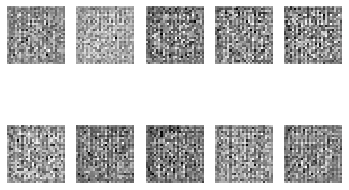

In [7]:
# Lets visualize some examples of the untrained fake
# images... they will probably still just look like 
# noise, but we can see how these functions work.

# 100 is arbitrary, but a commonly used value.
NOISE_DIM = 100
generator = create_generator(NOISE_DIM)

fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

for i in range(10):
    ax = plt.subplot(2, 5, i+1)
    ax.axis('off')
    
    # imshow only works for (h, w) or (h, w, color) IF color == 3 or 4
    # we have color == 1, so we use this annoying hack to slice off
    # the last dimension. (by taking the value at the 0th position,
    # which is the only position available since we're (28,28,1))
    plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

In [10]:
# Wonderfully noisy. 

# Okay, now lets connect our generator, discriminator, and let them
# try to outfox each other. 

# To do this, we'll create a new model that is composed of the 
# two other models. There are other ways to make a GAN but this 
# is easy to code up in keras, and works well. 

def create_gan(generator, discriminator):
    # The output of the generator is the input to the discriminator.
    # The output of the discriminator matches our lables (0, 1) for (fake, real)
    model = Sequential()
    model.add(generator)

    # When the GAN trains, it only trains the generator.
    # the discriminator has to be trained separately. 
    # This honestly seems like the wrong way to do this...
    # But apparently it's totally legit: https://github.com/keras-team/keras/issues/8585
    discriminator.trainable = False
    model.add(discriminator)
    
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    
    return model
    
# Okay, now lets train this thing!

# A lot of work has gone into figuring out strategies
# for training GANs, and some of the best practices include:

# Freezing the discriminator while we train the generator, this
# creates a stable target for the generator to work against. 

# Periodically updating the discriminator BY ITSELF with batches
# of fake images from the generator. 

# Inverting the label of "fake" images during generator training. 
#   In order to fool the discriminator, we invert the labels.
#   The idea is that when the discrimiator is doing a GOOD job 
#   (i.e. low loss / error) we need to tell the generator that its
#   doing a BAD job. A very quick way to achieve this is to flip
#   labels when training the generator. 


def train_gan(gan, generator, discriminator, noise_dim, batches, batch_size):
    for i in range(batches):
        real_batch_images, real_batch_labels = generate_real_batch(prepared_real_images, batch_size)
        fake_batch_images, fake_batch_labels = generate_fake_batch(generator, noise_dim, batch_size)

        # Concatenate the real and fake, to train the discriminator.
        images = np.concatenate((real_batch_images, fake_batch_images))
        labels = np.concatenate((real_batch_labels, fake_batch_labels))
        
        # Train the discriminator
        discriminator.train_on_batch(images, labels)
        
        # Make some noise for the full model to train on
        gan_input_vector = generate_noise_vector(noise_dim, batch_size)

        # In order to fool the discriminator, we invert the labels.
        # The idea is that when the discrimiator is doing a GOOD job 
        # (i.e. low loss / error) we need to tell the generator that its
        # doing a BAD job. A very quick way to achieve this is to flip
        # labels when training the generator. 
        gan_labels = np.ones((batch_size, 1))
        gan.train_on_batch(gan_input_vector, gan_labels)

/Users/tylerbettilyon/.local/share/virtualenvs/deep-learning-intro-1Adgpw9A/lib/python3.7/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


After 0 evaluations


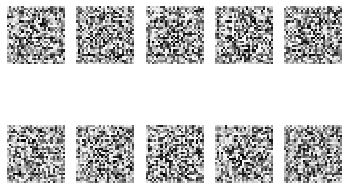

After 1 evaluations


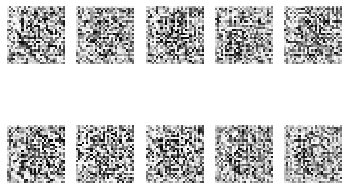

After 2 evaluations


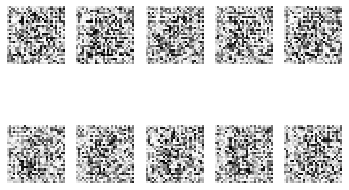

After 3 evaluations


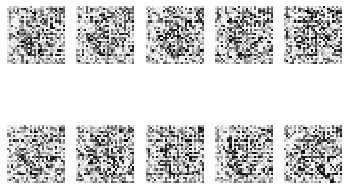

After 4 evaluations


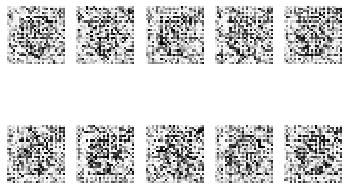

After 5 evaluations


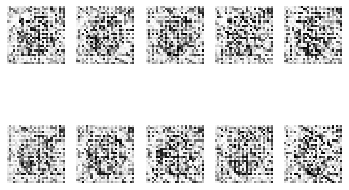

After 6 evaluations


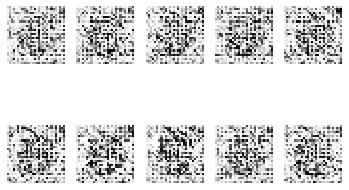

After 7 evaluations


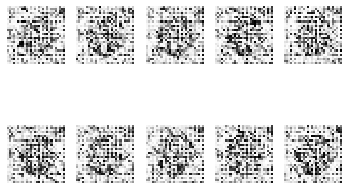

After 8 evaluations


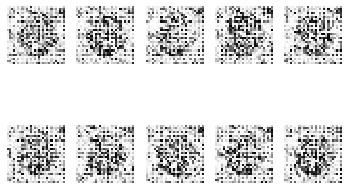

After 9 evaluations


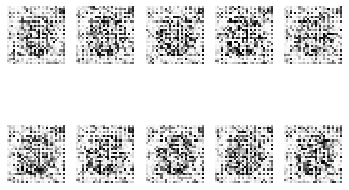

In [11]:
EVALUATION_ROUNDS = 10
BATCHES = 100
BATCH_SIZE = 256

# Lets get fresh copies of everything.
discriminator = create_discriminator(INPUT_SHAPE)
generator = create_generator(NOISE_DIM)
gan = create_gan(generator, discriminator)

for i in range(EVALUATION_ROUNDS):
    train_gan(gan, generator, discriminator, NOISE_DIM, BATCHES, BATCH_SIZE)
    print(f'After {i} evaluations')
    # To evaluate, we'll look at generated samples over time.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()

After 0 evaluations


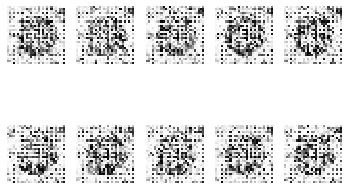

After 1 evaluations


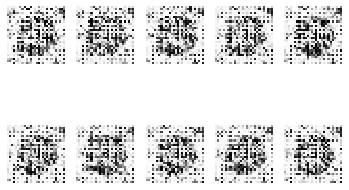

After 2 evaluations


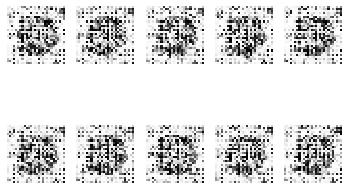

After 3 evaluations


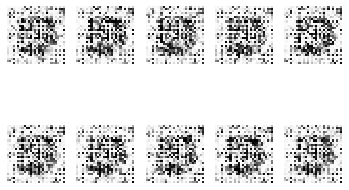

After 4 evaluations


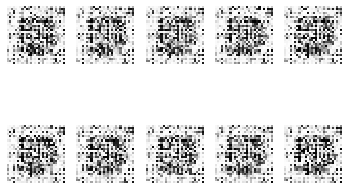

After 5 evaluations


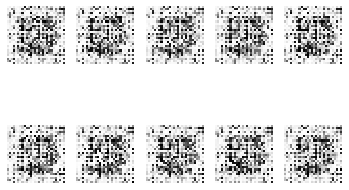

After 6 evaluations


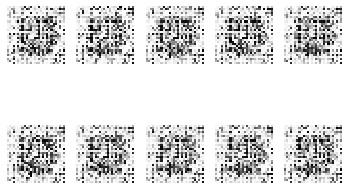

After 7 evaluations


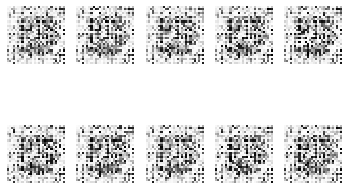

After 8 evaluations


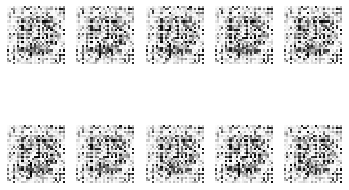

After 9 evaluations


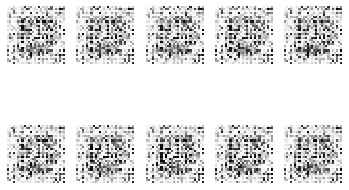

In [12]:
# Wow, not awesome yet... lets do tons more
for i in range(10):
    train_gan(gan, generator, discriminator, NOISE_DIM, 500, BATCH_SIZE) # note, 5x more batches per sample image
    print(f'After {i} evaluations')
    # To evaluate, we'll look at generated samples over time.
    fake_images, _ = generate_fake_batch(generator, NOISE_DIM, 10)

    for i in range(10):
        ax = plt.subplot(2, 5, i+1)
        ax.axis('off')
        plt.imshow(fake_images[i, :, :, 0], cmap='Greys')

    plt.show()